# Average Creature Stats by Mana Value

In this notebook i want to make my first attempt at understanding how creature stats can influence performance of a card in a limited environment. To do this, i chose to begin with the set *Adventures in the Forgotten Realms* (AFR for short) as it is a very simple set (no double sided cards).

## Adquiring the Data

The data i'll be using comes from [Scryfall's API](https://scryfall.com/docs/api) theres not much thought into this decision it's just the mtg data source that i like and know how to use. To access the data i wrote a python class that will handle the pagination of the query result immediately.

```
import requests
from time import sleep

class ScryfallCardQuery_v2:
    def __init__(self, query_string):
        self.response = requests.get('https://api.scryfall.com/cards/search?q=' + query_string).json()
        self.data = self.response['data']
        sleep(0.1)
        if self.response['has_more']:
            self.data += self.get_next_pages(self.response['next_page']) 
    
    def get_next_pages(self, next_page):
        next_data = requests.get(next_page).json()

        if next_data['has_more']:
            sleep(0.1)
            return next_data['data'] + self.get_next_pages(next_data['next_page'])
        else:
            return next_data['data']
```

To make a query with this class you just have to import it and send the scryfall query string as an argument. Given i want to see the common and uncommon creatures in AFR then my query should be: 

 `type:creature set:afr (rarity:common or r:uncommon) -is:rebalanced` 

the last bit of the query is required to prevent the alchemy rebalanced version of cards from popping up in the results. In my code i used the shorthand version of this query but the results should be the same.

 In addition to this, i want this resulting data to be stored as a pandas DataFrame which is designed for data manipulation

In [37]:
import pandas as pd
from ScryfallCardQuery import ScryfallCardQuery_v2 as scq

afr_query = 't:creature s:afr -is:rebalanced (r:c or r:u)' 
afr_creature_full_data = pd.DataFrame(scq(afr_query).data)

afr_creature_full_data.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,arena_id,tcgplayer_id,cardmarket_id,name,lang,...,edhrec_rank,preview,prices,related_uris,purchase_uris,flavor_text,penny_rank,all_parts,frame_effects,produced_mana
0,card,d9c6401a-e152-4acf-a2ca-75c484f296d5,753ead8c-f3f8-42fe-931d-79f5ee3ece54,[527331],91590,77149,243580,571887,Aberrant Mind Sorcerer,en,...,10635,"{'source': 'Neo Tokyo Project', 'source_uri': ...","{'usd': '0.04', 'usd_foil': '0.09', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://www.tcgplayer.com/produ...,NaN,NaN,NaN,NaN,NaN
1,card,fba82564-a9a9-4ded-a5fa-0e5fab2a3faa,6ec2d957-c6d9-469f-8190-8b621c490238,[527332],91592,77150,243149,571242,Air-Cult Elemental,en,...,15308,NaN,"{'usd': '0.01', 'usd_foil': '0.05', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://www.tcgplayer.com/produ...,"Elemental Evil distorts the natural elements, ...",NaN,NaN,NaN,NaN
2,card,fc45c9d4-ecc7-4a9d-9efe-f4b7d697dd97,9a17452d-3adb-42ec-99f8-0083740cefa0,[527289],91506,77107,243434,571841,Arborea Pegasus,en,...,16970,"{'source': 'Wizards of the Coast', 'source_uri...","{'usd': '0.01', 'usd_foil': '0.04', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://www.tcgplayer.com/produ...,The noble steeds of the elven gods can sometim...,NaN,NaN,NaN,NaN
3,card,dc457520-9947-4f65-bbe7-9b95bd2c23af,19b229c4-1c21-4c7c-a25e-4e8c1cd4ed4b,[527333],91594,77151,243275,571399,Arcane Investigator,en,...,11393,NaN,"{'usd': '0.03', 'usd_foil': '0.04', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://www.tcgplayer.com/produ...,NaN,13104.0,NaN,NaN,NaN
4,card,4177f57e-c239-47e8-ae50-5f593f6d54ec,2b51bbb3-1514-4a79-861f-b9cec9f0ec1b,[527417],91762,77235,243427,571854,Armory Veteran,en,...,15250,NaN,"{'usd': '0.02', 'usd_foil': '0.02', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://www.tcgplayer.com/produ...,"""This one is for goblins, this one is for owlb...",NaN,"[{'object': 'related_card', 'id': '423f13ba-e1...",NaN,NaN


Well thats a lot of data! in this query for every card there are 69 tracked features. 

In [38]:
afr_creature_full_data.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id', 'arena_id',
       'tcgplayer_id', 'cardmarket_id', 'name', 'lang', 'released_at', 'uri',
       'scryfall_uri', 'layout', 'highres_image', 'image_status', 'image_uris',
       'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power', 'toughness',
       'colors', 'color_identity', 'keywords', 'legalities', 'games',
       'reserved', 'foil', 'nonfoil', 'finishes', 'oversized', 'promo',
       'reprint', 'variation', 'set_id', 'set', 'set_name', 'set_type',
       'set_uri', 'set_search_uri', 'scryfall_set_uri', 'rulings_uri',
       'prints_search_uri', 'collector_number', 'digital', 'rarity',
       'card_back_id', 'artist', 'artist_ids', 'illustration_id',
       'border_color', 'frame', 'full_art', 'textless', 'booster',
       'story_spotlight', 'edhrec_rank', 'preview', 'prices', 'related_uris',
       'purchase_uris', 'flavor_text', 'penny_rank', 'all_parts',
       'frame_effects', 'produced_mana'],
      dtype='ob

But we are not really interested in all features. For now, we'll be looking at the most basic of features surrounding combat and visualization: card name, mana value (cmc), colors, power and toughness.

In [39]:
features = ['name', 'cmc', 'power', 'toughness', 'colors']
afr_creature_data = afr_creature_full_data[afr_creature_full_data.layout == 'normal'][features].sort_values(by=['toughness','power']).reset_index(drop=True)
afr_creature_data.head()

,name,cmc,power,toughness,colors
0,Blink Dog,3.0,1,1,[W]
1,Goblin Javelineer,1.0,1,1,[R]
2,Guild Thief,2.0,1,1,[U]
3,Ingenious Smith,2.0,1,1,[W]
4,Monk of the Open Hand,1.0,1,1,[W]


That looks good! but we can still do better. With the way the statline of creatures (power and toughness) is currently sorted we can only interact with them individually. The problem being that when we are assesing the quality of a creature and comparing them to one another both stats are a packaged deal. In order to aquire this relationship and additional column (or pandas Series) should be added where both stats are bundled as a string making it a categorical feature.

In [40]:
afr_creature_statline = pd.Series([str(card['power'])+'/'+str(card['toughness'])
                                                for i, card in afr_creature_data.iterrows()]).rename('statline')

afr_creature_data = pd.concat([afr_creature_data, afr_creature_statline], axis='columns')
afr_creature_data.head()


,name,cmc,power,toughness,colors,statline
0,Blink Dog,3.0,1,1,[W],1/1
1,Goblin Javelineer,1.0,1,1,[R],1/1
2,Guild Thief,2.0,1,1,[U],1/1
3,Ingenious Smith,2.0,1,1,[W],1/1
4,Monk of the Open Hand,1.0,1,1,[W],1/1


## Visualizing the Data

When visualizing this dataset we are interested in knowing **how much** power and toughness should be expected in a creature **at a given mana cost**. With that insight we should also be able to tell **which creatures** are poised to underperform or overperform at their given mana cost. these visualizations will be generated using seaborn.

### Statline Distribution at a Given CMC

In order to display the relationship of a creature statline and its cmc a heatmap should do the trick.


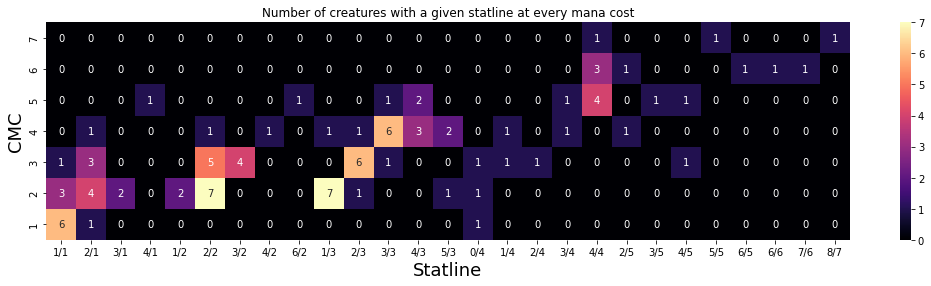

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

unique_statlines = [statline for statline in afr_creature_data.statline.unique()]
unique_cmc = sorted([int(cost) for cost in afr_creature_data.cmc.unique()], reverse=True)

statline_vs_cmc_data = pd.DataFrame({
    str(body):[afr_creature_data.name[(afr_creature_data.cmc == cmc) & (afr_creature_data.statline == body)].count() for cmc in unique_cmc] for body in unique_statlines
})

plt.figure(figsize=(18,4))
plt.title("Number of creatures with a given statline at every mana cost")

p = sns.heatmap(data=statline_vs_cmc_data, yticklabels=unique_cmc, annot=True, cmap='magma')

p.set_xlabel('Statline', fontsize=18)
p.set_ylabel('CMC', fontsize=18)

pass

And this is our result! Now we can start having a baseline to understand what statlines are better suited for early game combat and how often certain pieces of removal should be effective. The natural following step would be to compare the statlines available to every color pair or archetype. I plan to share my attempt at showcasing this insight in the following days.